# EXPLORATION 9. 영화리뷰 텍스트 감성분석하기

---

## Import

In [1]:
import os
import re
import pandas as pd
import numpy as np

import urllib.request
import matplotlib.pyplot as plt
%matplotlib inline


from konlpy.tag import Okt
from konlpy.tag import Mecab

from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.initializers import Constant
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

from collections import Counter
import gensim
from gensim.models import KeyedVectors
from gensim.models.keyedvectors import Word2VecKeyedVectors

## Dataset

In [2]:
train_data = pd.read_table('~/aiffel/sentiment_classification/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [3]:
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [4]:
def load_data(train_data, test_data, num_words=10000):
    # [[YOUR CODE]]
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 

    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence)
        temp_X = [word for word in temp_X if not word in stopwords]
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence)
        temp_X = [word for word in temp_X if not word in stopwords]
        X_test.append(temp_X)

    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}

    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]

    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))

    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

In [5]:
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [6]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [7]:
len(word_to_index)

10000

In [8]:
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

## Preprocessing

In [9]:
# 데이터셋 내 문장 길이 분포
total_data_text = list(X_train) + list(X_test)

num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092


In [10]:
# 적절한 최대 문장 길이 지정
max_tokens = np.mean(num_tokens) + 2.5 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

pad_sequences maxlen :  48
전체 문장의 0.9548784420929768%가 maxlen 설정값 이내에 포함됩니다. 


In [11]:
# keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가
X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre',
                                                        maxlen=maxlen)

X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre',
                                                       maxlen=maxlen)

In [12]:
print(X_train.shape)
print(X_test.shape)

(146182, 48)
(49157, 48)


In [13]:
# validation set 30000건 분리
x_val = X_train[:30000]   
y_val = y_train[:30000]

# validation set을 제외한 나머지
partial_x_train = X_train[30000:]  
partial_y_train = y_train[30000:]

In [14]:
print(x_val.shape)
print(y_val.shape)
print(partial_x_train.shape)
print(partial_y_train.shape)

(30000, 48)
(30000,)
(116182, 48)
(116182,)


## LSTM

### Model

In [15]:
vocab_size = 10000
word_vector_dim = 128

LSTM_ = keras.Sequential()
LSTM_.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
LSTM_.add(keras.layers.LSTM(128))
LSTM_.add(keras.layers.Dense(1, activation='sigmoid'))

In [16]:
LSTM_.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 128)         1280000   
_________________________________________________________________
lstm (LSTM)                  (None, 128)               131584    
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 1,411,713
Trainable params: 1,411,713
Non-trainable params: 0
_________________________________________________________________


### Train

In [17]:
LSTM_.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [21]:
early = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
check = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_bast_only=True)

In [22]:
LSTM_history = LSTM_.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    callbacks=[early, check],
                    batch_size=32,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
3628/3631 [============================>.] - ETA: 0s - loss: 0.3678 - accuracy: 0.8361
Epoch 00001: saving model to best_model.h5
3631/3631 [==============================] - 33s 9ms/step - loss: 0.3679 - accuracy: 0.8361 - val_loss: 0.3186 - val_accuracy: 0.8607
Epoch 2/20
3629/3631 [============================>.] - ETA: 0s - loss: 0.2820 - accuracy: 0.8804
Epoch 00002: saving model to best_model.h5
3631/3631 [==============================] - 32s 9ms/step - loss: 0.2820 - accuracy: 0.8804 - val_loss: 0.3077 - val_accuracy: 0.8659
Epoch 3/20
3626/3631 [============================>.] - ETA: 0s - loss: 0.2373 - accuracy: 0.9016
Epoch 00003: saving model to best_model.h5
3631/3631 [==============================] - 33s 9ms/step - loss: 0.2374 - accuracy: 0.9016 - val_loss: 0.3179 - val_accuracy: 0.8665
Epoch 4/20
3628/3631 [============================>.] - ETA: 0s - loss: 0.1971 - accuracy: 0.9192
Epoch 00004: saving model to best_model.h5
3631/3631 [=======================

In [23]:
loaded_model = load_model('best_model.h5')
results = loaded_model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.5328 - accuracy: 0.8506
[0.5328423380851746, 0.8506214618682861]


 ### Visualization

In [24]:
LSTM_history_dict = LSTM_history.history

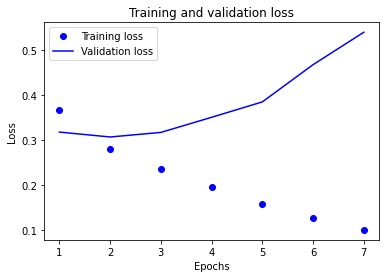

In [25]:
acc = LSTM_history_dict['accuracy']
val_acc = LSTM_history_dict['val_accuracy']
loss = LSTM_history_dict['loss']
val_loss = LSTM_history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

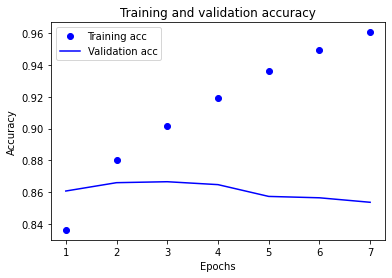

In [26]:
plt.clf()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### Embedding layer

In [28]:
embedding_layer = LSTM_.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)

(10000, 128)


In [30]:
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/LSTMword2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))

vectors = LSTM_.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [31]:
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['컴퓨터']
vector

array([ 0.1953111 , -0.07818211, -0.13025224,  0.04778629, -0.0626426 ,
       -0.13819109, -0.00083411,  0.1838617 ,  0.28355724, -0.1852018 ,
        0.18115915, -0.13103947, -0.26322278,  0.05727113, -0.01496439,
        0.00690731, -0.19887765,  0.06708807,  0.10878192, -0.0188668 ,
       -0.09288965,  0.08865335, -0.13897356,  0.01981358, -0.2857238 ,
        0.25313357,  0.1768667 , -0.3288269 ,  0.01954183, -0.09592935,
       -0.08810972,  0.24779156, -0.06591883,  0.14654711,  0.01628963,
       -0.1041819 ,  0.00982738,  0.4474766 ,  0.01968251,  0.09863592,
        0.25749967,  0.23147266,  0.12301844, -0.06851129,  0.17670731,
       -0.19361821,  0.3482947 , -0.167777  , -0.08770506,  0.0670478 ,
        0.2624596 , -0.0922872 , -0.21982394,  0.11234916,  0.05913242,
       -0.00972744, -0.20708393, -0.00767379, -0.13657525, -0.02869871,
        0.1435427 , -0.02323475,  0.05602733, -0.10143601, -0.28603417,
       -0.20622286,  0.07349464, -0.20742743, -0.02164286, -0.21

In [32]:
word_vectors.similar_by_word("감동")

[('리암니슨', 0.8664875030517578),
 ('입감', 0.8513984084129333),
 ('비포', 0.84912109375),
 ('풍성', 0.845466136932373),
 ('끌리', 0.8450627326965332),
 ('진화', 0.8437305092811584),
 ('명품', 0.8436261415481567),
 ('강렬', 0.8421682119369507),
 ('사로잡', 0.8419795632362366),
 ('커버', 0.8416486978530884)]

### 한국어 Word2Vec

In [33]:
word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/ko.bin'
word2vec = gensim.models.Word2Vec.load(word2vec_path)
vector = word2vec['컴퓨터']
vector

/home/aiffel0046/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


array([-1.517628  , -0.8935504 , -1.4352998 ,  1.5069847 , -1.5178334 ,
        1.1542678 , -2.94064   ,  1.1850045 ,  0.19959009, -1.5288961 ,
       -1.7067502 , -2.1892095 , -0.20728938, -2.2606812 , -2.2283888 ,
        0.32318738, -0.2845471 , -0.07731772, -0.86269003, -1.1722927 ,
       -0.91062415,  0.8440715 ,  0.903278  , -0.84685427,  0.7023384 ,
       -2.1920419 , -0.47571626, -0.60159504, -0.68860835,  0.18944737,
        0.5319404 ,  0.73058116, -0.9658133 , -1.0123725 , -0.36183038,
        2.5851305 ,  0.66589296, -1.7231252 ,  1.7576753 ,  0.88845277,
        1.5791365 , -4.430691  ,  0.36731872,  0.69481534, -0.46041563,
        1.742655  , -1.5077016 ,  0.72209424, -0.04532204, -0.6557301 ,
       -0.71276623,  0.26522732, -0.17656395, -2.4720876 , -0.845565  ,
        0.23591152,  1.3414925 ,  0.77577615, -2.289371  , -0.8078124 ,
        1.4359473 ,  0.22882733, -1.08867   ,  1.2607764 , -1.7469797 ,
        0.06542054,  0.39896825, -0.3160832 , -1.7257563 ,  0.54

In [34]:
word2vec.similar_by_word("감동")

/home/aiffel0046/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  """Entry point for launching an IPython kernel.


[('감명', 0.7177015542984009),
 ('감격', 0.6908232569694519),
 ('실망', 0.6267645359039307),
 ('감화', 0.6191877126693726),
 ('감탄', 0.6140127778053284),
 ('칭찬', 0.6059398055076599),
 ('존경', 0.6032299995422363),
 ('자극', 0.594598650932312),
 ('감복', 0.5902734994888306),
 ('호응', 0.5850393772125244)]

In [35]:
vocab_size = 10000
word_vector_dim = 200

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

/home/aiffel0046/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  import sys
/home/aiffel0046/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [36]:
vocab_size = 10000
word_vector_dim = 200

LSTM_ko = keras.Sequential()
LSTM_ko.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),
                                 input_length=maxlen, 
                                 trainable=True))
LSTM_ko.add(keras.layers.LSTM(64))
LSTM_ko.add(keras.layers.Dense(256, activation='relu'))
LSTM_ko.add(keras.layers.Dense(1, activation='sigmoid'))

In [37]:
LSTM_ko.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 48, 200)           2000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                67840     
_________________________________________________________________
dense_1 (Dense)              (None, 256)               16640     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 2,084,737
Trainable params: 2,084,737
Non-trainable params: 0
_________________________________________________________________


In [38]:
LSTM_ko.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [39]:
ealry_ko = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
check_ko = ModelCheckpoint('best_model_ko.h5', monitor='val_acc', mode='max', verbose=1, save_bast_only=True)

In [40]:
history = LSTM_ko.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    callbacks=[ealry_ko, check_ko],
                    batch_size=32,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
3631/3631 [==============================] - ETA: 0s - loss: 0.3854 - accuracy: 0.8252
Epoch 00001: saving model to best_model_ko.h5
3631/3631 [==============================] - 50s 14ms/step - loss: 0.3854 - accuracy: 0.8252 - val_loss: 0.3240 - val_accuracy: 0.8584
Epoch 2/20
3631/3631 [==============================] - ETA: 0s - loss: 0.2934 - accuracy: 0.8751
Epoch 00002: saving model to best_model_ko.h5
3631/3631 [==============================] - 50s 14ms/step - loss: 0.2934 - accuracy: 0.8751 - val_loss: 0.3134 - val_accuracy: 0.8634
Epoch 3/20
3631/3631 [==============================] - ETA: 0s - loss: 0.2511 - accuracy: 0.8948
Epoch 00003: saving model to best_model_ko.h5
3631/3631 [==============================] - 49s 14ms/step - loss: 0.2511 - accuracy: 0.8948 - val_loss: 0.3138 - val_accuracy: 0.8692
Epoch 4/20
3629/3631 [============================>.] - ETA: 0s - loss: 0.2135 - accuracy: 0.9128
Epoch 00004: saving model to best_model_ko.h5
3631/3631 [========

In [41]:
loaded_model = load_model('best_model_ko.h5')
results = loaded_model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.4821 - accuracy: 0.8564
[0.4820862114429474, 0.8563785552978516]


## Conv1D

### Model

In [42]:
vocab_size = 10000
word_vector_dim = 64

conv1d_model = keras.Sequential()
conv1d_model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
conv1d_model.add(keras.layers.Conv1D(64, 7, activation='relu'))
conv1d_model.add(keras.layers.MaxPooling1D(5))
conv1d_model.add(keras.layers.Conv1D(64, 7, activation='relu'))
conv1d_model.add(keras.layers.GlobalMaxPooling1D())
conv1d_model.add(keras.layers.Dense(128, activation='relu'))
conv1d_model.add(keras.layers.Dense(1, activation='sigmoid'))

In [43]:
conv1d_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 64)          640000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 64)          28736     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 64)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 64)          28736     
_________________________________________________________________
global_max_pooling1d (Global (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                

### Train

In [44]:
conv1d_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [45]:
conv1d_history = conv1d_model.fit(partial_x_train,
                    partial_y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
3631/3631 [==============================] - 24s 7ms/step - loss: 0.4126 - accuracy: 0.8030 - val_loss: 0.3656 - val_accuracy: 0.8285
Epoch 2/10
3631/3631 [==============================] - 17s 5ms/step - loss: 0.3082 - accuracy: 0.8633 - val_loss: 0.3629 - val_accuracy: 0.8322
Epoch 3/10
3631/3631 [==============================] - 17s 5ms/step - loss: 0.2282 - accuracy: 0.9012 - val_loss: 0.4160 - val_accuracy: 0.8260
Epoch 4/10
3631/3631 [==============================] - 17s 5ms/step - loss: 0.1590 - accuracy: 0.9322 - val_loss: 0.5282 - val_accuracy: 0.8242
Epoch 5/10
3631/3631 [==============================] - 17s 5ms/step - loss: 0.1198 - accuracy: 0.9474 - val_loss: 0.6117 - val_accuracy: 0.8129
Epoch 6/10
3631/3631 [==============================] - 17s 5ms/step - loss: 0.0985 - accuracy: 0.9564 - val_loss: 0.6995 - val_accuracy: 0.8141
Epoch 7/10
3631/3631 [==============================] - 17s 5ms/step - loss: 0.0831 - accuracy: 0.9623 - val_loss: 0.7770 - val_ac

In [46]:
results = conv1d_model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 4s - loss: 1.1400 - accuracy: 0.8090
[1.1400208473205566, 0.8089997172355652]


 ### Visualization

In [47]:
conv1d_history_dict = conv1d_history.history

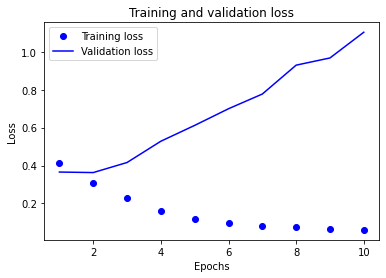

In [48]:
acc = conv1d_history_dict['accuracy']
val_acc = conv1d_history_dict['val_accuracy']
loss = conv1d_history_dict['loss']
val_loss = conv1d_history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

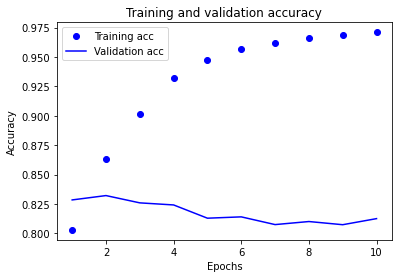

In [49]:
plt.clf()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### Embedding layer

In [50]:
embedding_layer = conv1d_model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)

(10000, 64)


In [51]:
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/conv1d_word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))

vectors = conv1d_model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [52]:
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['컴퓨터']
vector

array([ 0.06361371, -0.06751762,  0.06527569,  0.10584253, -0.05958762,
       -0.025139  , -0.1889293 ,  0.05408068, -0.1257165 , -0.22453459,
        0.08517146, -0.08068184, -0.03929665,  0.08729344,  0.20420666,
       -0.06758779,  0.07310896, -0.11994239,  0.02916998, -0.15843967,
        0.14569984,  0.3631978 ,  0.07961382,  0.1074208 ,  0.22394885,
       -0.0620795 ,  0.10374705, -0.15096468, -0.12218057,  0.07548838,
        0.12686993, -0.02395142,  0.28049594,  0.01398078,  0.01775759,
        0.01355522, -0.2769312 ,  0.00770285,  0.00477289,  0.08419724,
       -0.03155058, -0.18642132,  0.15716654,  0.1855269 , -0.03087553,
       -0.20677675, -0.47202572,  0.10899175,  0.10004392,  0.01345717,
       -0.09356957,  0.26262182, -0.04969022, -0.4367792 ,  0.00151107,
        0.06415954, -0.02350914, -0.30443382, -0.06700101,  0.09561493,
       -0.0762158 , -0.02350251, -0.06707862, -0.332499  ], dtype=float32)

In [53]:
word_vectors.similar_by_word("감동")

[('레슬리', 0.6983741521835327),
 ('짠', 0.6897995471954346),
 ('very', 0.6844871640205383),
 ('새록새록', 0.6776750087738037),
 ('쵝오', 0.6723877191543579),
 ('비노쉬', 0.6673214435577393),
 ('치유', 0.661548376083374),
 ('펼쳐지', 0.6594976186752319),
 ('오래오래', 0.6590533256530762),
 ('Very', 0.6560702919960022)]

### 한국어 Word2Vec

In [54]:
word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/ko.bin'
word2vec = gensim.models.Word2Vec.load(word2vec_path)
vector = word2vec['컴퓨터']
vector

/home/aiffel0046/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


array([-1.517628  , -0.8935504 , -1.4352998 ,  1.5069847 , -1.5178334 ,
        1.1542678 , -2.94064   ,  1.1850045 ,  0.19959009, -1.5288961 ,
       -1.7067502 , -2.1892095 , -0.20728938, -2.2606812 , -2.2283888 ,
        0.32318738, -0.2845471 , -0.07731772, -0.86269003, -1.1722927 ,
       -0.91062415,  0.8440715 ,  0.903278  , -0.84685427,  0.7023384 ,
       -2.1920419 , -0.47571626, -0.60159504, -0.68860835,  0.18944737,
        0.5319404 ,  0.73058116, -0.9658133 , -1.0123725 , -0.36183038,
        2.5851305 ,  0.66589296, -1.7231252 ,  1.7576753 ,  0.88845277,
        1.5791365 , -4.430691  ,  0.36731872,  0.69481534, -0.46041563,
        1.742655  , -1.5077016 ,  0.72209424, -0.04532204, -0.6557301 ,
       -0.71276623,  0.26522732, -0.17656395, -2.4720876 , -0.845565  ,
        0.23591152,  1.3414925 ,  0.77577615, -2.289371  , -0.8078124 ,
        1.4359473 ,  0.22882733, -1.08867   ,  1.2607764 , -1.7469797 ,
        0.06542054,  0.39896825, -0.3160832 , -1.7257563 ,  0.54

In [56]:
word2vec.similar_by_word("감동")

/home/aiffel0046/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  """Entry point for launching an IPython kernel.


[('감명', 0.7177015542984009),
 ('감격', 0.6908232569694519),
 ('실망', 0.6267645359039307),
 ('감화', 0.6191877126693726),
 ('감탄', 0.6140127778053284),
 ('칭찬', 0.6059398055076599),
 ('존경', 0.6032299995422363),
 ('자극', 0.594598650932312),
 ('감복', 0.5902734994888306),
 ('호응', 0.5850393772125244)]

In [57]:
vocab_size = 10000
word_vector_dim = 200

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

/home/aiffel0046/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  import sys
/home/aiffel0046/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [58]:
vocab_size = 10000
word_vector_dim = 200

conv1d_model_ko = keras.Sequential()
conv1d_model_ko.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),
                                 input_length=maxlen, 
                                 trainable=True))
conv1d_model_ko.add(keras.layers.Conv1D(64, 7, activation='relu'))
conv1d_model_ko.add(keras.layers.MaxPooling1D(5))
conv1d_model_ko.add(keras.layers.Conv1D(64, 7, activation='relu'))
conv1d_model_ko.add(keras.layers.GlobalMaxPooling1D())
conv1d_model_ko.add(keras.layers.Dense(128, activation='relu'))
conv1d_model_ko.add(keras.layers.Dense(1, activation='sigmoid'))

In [59]:
conv1d_model_ko.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 48, 200)           2000000   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 42, 64)            89664     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 8, 64)             0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 2, 64)             28736     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                

In [60]:
conv1d_model_ko.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [61]:
history = conv1d_model_ko.fit(partial_x_train,
                    partial_y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
3631/3631 [==============================] - 50s 14ms/step - loss: 0.4692 - accuracy: 0.7665 - val_loss: 0.3995 - val_accuracy: 0.8142
Epoch 2/10
3631/3631 [==============================] - 46s 13ms/step - loss: 0.3580 - accuracy: 0.8371 - val_loss: 0.3892 - val_accuracy: 0.8230
Epoch 3/10
3631/3631 [==============================] - 46s 13ms/step - loss: 0.3106 - accuracy: 0.8617 - val_loss: 0.3828 - val_accuracy: 0.8246
Epoch 4/10
3631/3631 [==============================] - 45s 12ms/step - loss: 0.2645 - accuracy: 0.8842 - val_loss: 0.4017 - val_accuracy: 0.8268
Epoch 5/10
3631/3631 [==============================] - 44s 12ms/step - loss: 0.2190 - accuracy: 0.9053 - val_loss: 0.4404 - val_accuracy: 0.8181
Epoch 6/10
3631/3631 [==============================] - 44s 12ms/step - loss: 0.1785 - accuracy: 0.9235 - val_loss: 0.5034 - val_accuracy: 0.8151
Epoch 7/10
3631/3631 [==============================] - 45s 12ms/step - loss: 0.1497 - accuracy: 0.9360 - val_loss: 0.5691 -

In [62]:
results = conv1d_model_ko.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.8382 - accuracy: 0.8069
[0.8382001519203186, 0.8069247603416443]


## GlobalMaxPooling

### Model

In [63]:
vocab_size = 10000
word_vector_dim = 64

GMP_model = keras.Sequential()
GMP_model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
GMP_model.add(keras.layers.GlobalMaxPooling1D())
GMP_model.add(keras.layers.Dense(8, activation='relu'))
GMP_model.add(keras.layers.Dense(1, activation='sigmoid'))

In [64]:
GMP_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 64)          640000    
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 8)                 520       
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 9         
Total params: 640,529
Trainable params: 640,529
Non-trainable params: 0
_________________________________________________________________


### Train

In [65]:
GMP_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [66]:
GMP_history = GMP_model.fit(partial_x_train,
                    partial_y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
3631/3631 [==============================] - 14s 4ms/step - loss: 0.3910 - accuracy: 0.8278 - val_loss: 0.3407 - val_accuracy: 0.8519
Epoch 2/10
3631/3631 [==============================] - 14s 4ms/step - loss: 0.3026 - accuracy: 0.8729 - val_loss: 0.3379 - val_accuracy: 0.8533
Epoch 3/10
3631/3631 [==============================] - 14s 4ms/step - loss: 0.2599 - accuracy: 0.8939 - val_loss: 0.3488 - val_accuracy: 0.8526
Epoch 4/10
3631/3631 [==============================] - 14s 4ms/step - loss: 0.2231 - accuracy: 0.9114 - val_loss: 0.3700 - val_accuracy: 0.8521
Epoch 5/10
3631/3631 [==============================] - 14s 4ms/step - loss: 0.1908 - accuracy: 0.9259 - val_loss: 0.3999 - val_accuracy: 0.8470
Epoch 6/10
3631/3631 [==============================] - 14s 4ms/step - loss: 0.1620 - accuracy: 0.9382 - val_loss: 0.4434 - val_accuracy: 0.8418
Epoch 7/10
3631/3631 [==============================] - 14s 4ms/step - loss: 0.1365 - accuracy: 0.9487 - val_loss: 0.4858 - val_ac

In [67]:
results = GMP_model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.6587 - accuracy: 0.8299
[0.658710777759552, 0.829871654510498]


 ### Visualization

In [68]:
GMP_history_dict = GMP_history.history

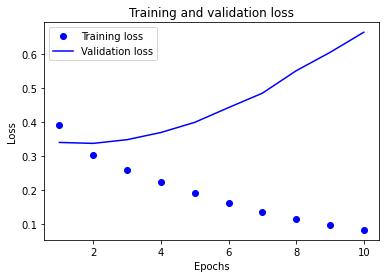

In [69]:
acc = GMP_history_dict['accuracy']
val_acc = GMP_history_dict['val_accuracy']
loss = GMP_history_dict['loss']
val_loss = GMP_history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

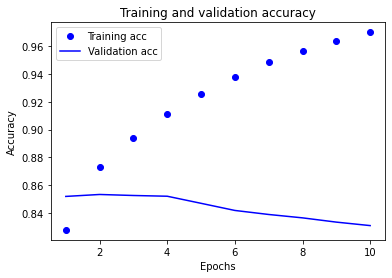

In [70]:
plt.clf()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### Embedding layer

In [71]:
embedding_layer = GMP_model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)

(10000, 64)


In [72]:
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/GMP_word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))

vectors = GMP_model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [73]:
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['컴퓨터']
vector

array([-0.17393857, -0.03324883, -0.04885576,  0.32420543,  0.1437811 ,
        0.10377556, -0.18482068, -0.14453569, -0.2561563 , -0.19028051,
       -0.16982259, -0.05497076, -0.13645838, -0.04997913, -0.18137082,
       -0.06153655, -0.15147983, -0.15774319, -0.12044641,  0.15942292,
       -0.1547893 , -0.03252633, -0.0740363 ,  0.16571634, -0.11295549,
        0.15701129, -0.18635422, -0.00384099, -0.2038382 , -0.15675014,
       -0.10963397,  0.0908593 , -0.19602312, -0.06584185,  0.00364739,
       -0.04475515, -0.07434149, -0.15569612, -0.19730411, -0.1757407 ,
       -0.18134925,  0.10022935, -0.20817757,  0.01130297,  0.15097506,
       -0.15728447, -0.08794313,  0.00361909,  0.34107056,  0.00647292,
       -0.03834957, -0.05902238, -0.04968559, -0.06780867, -0.11449554,
       -0.16840295, -0.01254093,  0.14600965, -0.13220741, -0.1431258 ,
       -0.17298174, -0.17066872, -0.03139625, -0.13363326], dtype=float32)

In [74]:
word_vectors.similar_by_word("감동")

[('흐흐', 0.7323527932167053),
 ('사랑', 0.7314023971557617),
 ('엇다', 0.7153211832046509),
 ('괜찮', 0.707036018371582),
 ('SF', 0.7039943933486938),
 ('줍니다', 0.6938197016716003),
 ('모두', 0.6934688687324524),
 ('반전', 0.6934455633163452),
 ('첩보', 0.6926800608634949),
 ('매우', 0.6862794160842896)]

### 한국어 Word2Vec

In [75]:
word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/ko.bin'
word2vec = gensim.models.Word2Vec.load(word2vec_path)
vector = word2vec['컴퓨터']
vector

/home/aiffel0046/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


array([-1.517628  , -0.8935504 , -1.4352998 ,  1.5069847 , -1.5178334 ,
        1.1542678 , -2.94064   ,  1.1850045 ,  0.19959009, -1.5288961 ,
       -1.7067502 , -2.1892095 , -0.20728938, -2.2606812 , -2.2283888 ,
        0.32318738, -0.2845471 , -0.07731772, -0.86269003, -1.1722927 ,
       -0.91062415,  0.8440715 ,  0.903278  , -0.84685427,  0.7023384 ,
       -2.1920419 , -0.47571626, -0.60159504, -0.68860835,  0.18944737,
        0.5319404 ,  0.73058116, -0.9658133 , -1.0123725 , -0.36183038,
        2.5851305 ,  0.66589296, -1.7231252 ,  1.7576753 ,  0.88845277,
        1.5791365 , -4.430691  ,  0.36731872,  0.69481534, -0.46041563,
        1.742655  , -1.5077016 ,  0.72209424, -0.04532204, -0.6557301 ,
       -0.71276623,  0.26522732, -0.17656395, -2.4720876 , -0.845565  ,
        0.23591152,  1.3414925 ,  0.77577615, -2.289371  , -0.8078124 ,
        1.4359473 ,  0.22882733, -1.08867   ,  1.2607764 , -1.7469797 ,
        0.06542054,  0.39896825, -0.3160832 , -1.7257563 ,  0.54

In [76]:
word2vec.similar_by_word("감동")

/home/aiffel0046/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  """Entry point for launching an IPython kernel.


[('감명', 0.7177015542984009),
 ('감격', 0.6908232569694519),
 ('실망', 0.6267645359039307),
 ('감화', 0.6191877126693726),
 ('감탄', 0.6140127778053284),
 ('칭찬', 0.6059398055076599),
 ('존경', 0.6032299995422363),
 ('자극', 0.594598650932312),
 ('감복', 0.5902734994888306),
 ('호응', 0.5850393772125244)]

In [77]:
vocab_size = 10000
word_vector_dim = 200

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

/home/aiffel0046/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  import sys
/home/aiffel0046/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [78]:
vocab_size = 10000
word_vector_dim = 200

GMP_model_ko = keras.Sequential()
GMP_model_ko.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),
                                 input_length=maxlen, 
                                 trainable=True))
GMP_model_ko.add(keras.layers.GlobalMaxPooling1D())
GMP_model_ko.add(keras.layers.Dense(8, activation='relu'))
GMP_model_ko.add(keras.layers.Dense(1, activation='sigmoid'))

In [79]:
GMP_model_ko.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 48, 200)           2000000   
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 200)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 8)                 1608      
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 9         
Total params: 2,001,617
Trainable params: 2,001,617
Non-trainable params: 0
_________________________________________________________________


In [80]:
GMP_model_ko.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [81]:
history = GMP_model_ko.fit(partial_x_train,
                    partial_y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
3631/3631 [==============================] - 45s 12ms/step - loss: 0.5516 - accuracy: 0.7047 - val_loss: 0.4525 - val_accuracy: 0.7875
Epoch 2/10
3631/3631 [==============================] - 45s 12ms/step - loss: 0.4182 - accuracy: 0.8076 - val_loss: 0.4041 - val_accuracy: 0.8145
Epoch 3/10
3631/3631 [==============================] - 45s 12ms/step - loss: 0.3684 - accuracy: 0.8356 - val_loss: 0.3882 - val_accuracy: 0.8256
Epoch 4/10
3631/3631 [==============================] - 46s 13ms/step - loss: 0.3332 - accuracy: 0.8551 - val_loss: 0.3794 - val_accuracy: 0.8317
Epoch 5/10
3631/3631 [==============================] - 45s 13ms/step - loss: 0.3053 - accuracy: 0.8701 - val_loss: 0.3881 - val_accuracy: 0.8290
Epoch 6/10
3631/3631 [==============================] - 46s 13ms/step - loss: 0.2807 - accuracy: 0.8832 - val_loss: 0.3810 - val_accuracy: 0.8348
Epoch 7/10
3631/3631 [==============================] - 44s 12ms/step - loss: 0.2589 - accuracy: 0.8936 - val_loss: 0.4110 -

In [83]:
results = GMP_model_ko.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.4332 - accuracy: 0.8307
[0.43318501114845276, 0.8307057023048401]


## Report

LSTM, Conv1D, GlobalMaxPooling 3가지 모델을 사용해보았습니다.  
이 중 LSTM의 성능이 가장 좋았습니다.  
* 0.850  

<br>
한국어 Word2Vec도 사용해보았는데, 사용할 경우 성능이 약간 더 향상되었습니다.  

* LSTM 성능 : 0.856